# Quality Metrics and Reconstruction Demo

Demonstrate the use of full reference metrics by comparing the reconstruction of a simulated phantom using SIRT, ART, and MLEM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from xdesign import *

In [2]:
NPIXEL = 128

## Generate a phantom

Use one of XDesign's various pre-made and procedurally generated phantoms.


In [21]:
np.random.seed(0)
soil_like_phantom = Softwood()

Generate a figure showing the phantom and save the discretized ground truth map for later.

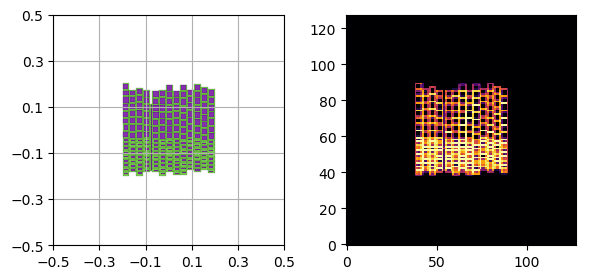

In [22]:
discrete = sidebyside(soil_like_phantom, NPIXEL)
plt.savefig('Soil_sidebyside.png', dpi='figure',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=False)
plt.show()

## Simulate data acquisition

Generate a list of probe coordinates to simulate data acquisition for parallel beam around 180 degrees.

In [23]:
angles = np.linspace(0, np.pi, NPIXEL, endpoint=False),
positions = np.linspace(0, 1, NPIXEL, endpoint=False) - 0.5 + 1/NPIXEL/2
theta, h = np.meshgrid(angles, positions)

Make a probe.

In [24]:
probe = Probe(size=1/NPIXEL)

Use the probe to measure the phantom.

In [25]:
sino = probe.measure(soil_like_phantom, theta, h)

In [26]:
# Transform data from attenuated intensity to attenuation coefficient
sino = -np.log(sino)

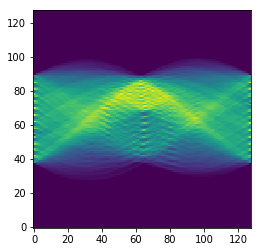

In [27]:
plt.imshow(sino.reshape(NPIXEL, NPIXEL), cmap='viridis', origin='lower')
plt.show()

## Reconstruct

Reconstruct the phantom using 3 different techniques: ART, SIRT, and MLEM.

In [28]:
niter = 32  # number of iterations
gmin = [-0.5, -0.5]
gsize = [1, 1]
data = sino

init = np.full((NPIXEL, NPIXEL), 1e-12)
rec_art = art(gmin, gsize, data, theta, h, init, niter)


init = np.full((NPIXEL, NPIXEL), 1e-12)
rec_sirt = sirt(gmin, gsize, data, theta, h, init, niter)


init = np.full((NPIXEL, NPIXEL), 1e-12)
rec_mlem = mlem(gmin, gsize, data, theta, h, init, niter)

[##########] 100.00%
[##########] 100.00%
[##########] 100.00%


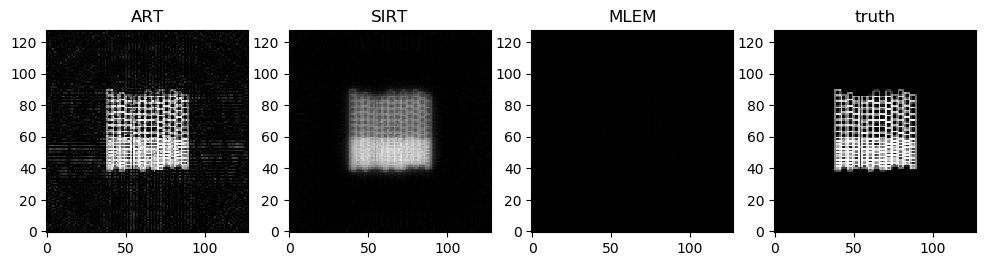

In [29]:
plt.figure(figsize=(12,4), dpi=100)
plt.subplot(141)
plt.imshow(rec_art, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.title('ART')
plt.subplot(142)
plt.imshow(rec_sirt, cmap='gray', interpolation='none', origin='lower', vmin=0, vmax=1)
plt.title('SIRT')
plt.subplot(143)
plt.imshow(rec_mlem, cmap='gray', interpolation='none', origin='lower', vmin=0, vmax=1)
plt.title('MLEM')
plt.subplot(144)
plt.imshow(discrete, cmap='gray', interpolation='none', origin='lower', vmin=0, vmax=1)
plt.title('truth')
plt.show()

## Quality Metrics

Compute local quality for each reconstruction using MS-SSIM, a convolution based quality metric.

In [30]:
quality = list()
for rec in [rec_art, rec_sirt, rec_mlem]:
    scales, mscore, qmap = compute_msssim(discrete, rec)
    quality.append(mscore)

Plot the average quality at for each reconstruction. Then display the local quality map for each reconstruction to see why certain reconstructions are ranked higher than others.

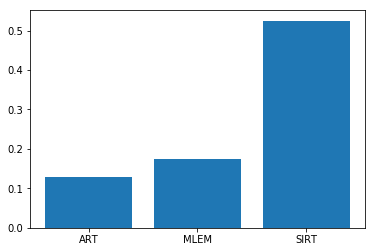

In [31]:
plt.figure()
plt.bar(["ART", "SIRT", "MLEM"], quality)
plt.show()